In [43]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

In [44]:
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage4.h5','train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage4.h5','test_df',mode='r')

In [3]:
df_final_train.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09


In [4]:
df_final_test.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,848424,784690,1,0,0.0,0.029161,0.0,14,6,9,...,5.904807e-11,2.701538e-12,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12
1,483294,1255532,1,0,0.0,0.000000,0.0,17,1,19,...,2.545382e-10,2.248568e-14,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14


In [5]:
g=nx.read_edgelist('train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

In [6]:
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


In [45]:
def Preferntial_Attachment_followers(a,b):                                 #computing preferential attachment of followers
    pref_follower=len(set(g.predecessors(a)))*len(set(g.predecessors(b)))
    return pref_follower

In [46]:
def Preferntial_Attachment_followee(a,b):                                 #computing preferential attachment of followee
    pref_followee=len(set(g.successors(a)))*len(set(g.successors(b)))
    return pref_followee

In [47]:
df_final_train['preferential_attach_followers'] = df_final_train.apply(lambda row:
                                            Preferntial_Attachment_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['preferential_attach_followers'] = df_final_test.apply(lambda row:
                                            Preferntial_Attachment_followers(row['source_node'],row['destination_node']),axis=1)

df_final_train['preferential_attach_followee'] = df_final_train.apply(lambda row:
                                            Preferntial_Attachment_followee(row['source_node'],row['destination_node']),axis=1)
df_final_test['preferential_attach_followee'] = df_final_test.apply(lambda row:
                                            Preferntial_Attachment_followee(row['source_node'],row['destination_node']),axis=1)

In [48]:
df_final_train['svd_dot_u']=df_final_train.svd_u_s_1*df_final_train.svd_u_d_1+df_final_train.svd_u_s_2*df_final_train.svd_u_d_2+df_final_train.svd_u_s_3*df_final_train.svd_u_d_3++df_final_train.svd_u_s_4*df_final_train.svd_u_d_4+df_final_train.svd_u_s_5*df_final_train.svd_u_d_5+df_final_train.svd_u_s_6*df_final_train.svd_u_d_6
df_final_train['svd_dot_v']=df_final_train.svd_v_s_1*df_final_train.svd_v_d_1+df_final_train.svd_v_s_2*df_final_train.svd_v_d_2+df_final_train.svd_v_s_3*df_final_train.svd_v_d_3++df_final_train.svd_v_s_4*df_final_train.svd_v_d_4+df_final_train.svd_v_s_5*df_final_train.svd_v_d_5+df_final_train.svd_v_s_6*df_final_train.svd_v_d_6

#===================================================================================# Computing svd dot features

df_final_test['svd_dot_u']=df_final_test.svd_u_s_1*df_final_test.svd_u_d_1+df_final_test.svd_u_s_2*df_final_test.svd_u_d_2+df_final_test.svd_u_s_3*df_final_test.svd_u_d_3++df_final_test.svd_u_s_4*df_final_test.svd_u_d_4+df_final_test.svd_u_s_5*df_final_test.svd_u_d_5+df_final_test.svd_u_s_6*df_final_test.svd_u_d_6
df_final_test['svd_dot_v']=df_final_test.svd_v_s_1*df_final_test.svd_v_d_1+df_final_test.svd_v_s_2*df_final_test.svd_v_d_2+df_final_test.svd_v_s_3*df_final_test.svd_v_d_3++df_final_test.svd_v_s_4*df_final_test.svd_v_d_4+df_final_test.svd_v_s_5*df_final_test.svd_v_d_5+df_final_test.svd_v_s_6*df_final_test.svd_v_d_6



In [49]:
def normalize(df,feature_name):
    max_value = df[feature_name].max()          #Normalizing the values function
    min_value = df[feature_name].min()
    df[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return df

In [50]:
df_final_train=normalize(df_final_train,'preferential_attach_followers')
df_final_train=normalize(df_final_train,'preferential_attach_followee')
df_final_test=normalize(df_final_test,'preferential_attach_followers')
df_final_test=normalize(df_final_test,'preferential_attach_followee')     #Normalizing preferential attachment features

In [51]:
df_final_train.shape

(100002, 58)

In [52]:
df_final_test.shape

(50002, 58)

In [53]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'preferential_attach_followers', 'preferential_attach_followee',
       'svd_dot_u', 'svd_dot_v'],
      dtype='object')

In [54]:
df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'preferential_attach_followers', 'preferential_attach_followee',
       'svd_dot_u', 'svd_dot_v'],
      dtype='object')

In [55]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [56]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

# Best hyperparameter tuning using RandomizedSearchcv

In [57]:
x_cfl=XGBClassifier()

prams = {"learning_rate": [0.1, 0.2, 0.3,0.4,0.5],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [3,5,10],
               "colsample_bytree": [0.1,0.3,0.5,1],
               "subsample": [0.1,0.3,0.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators":[10,12,15,20]}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,scoring='f1',verbose=10,n_jobs=-1,random_state=42)
random_cfl.fit(df_final_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:   20.3s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:   25.1s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   30.6s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=Non...
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.1, 0.3, 0.5, 1],
                                        'gamma': [0.01, 0.1, 0.3, 0.5, 1, 1.5,
      

In [58]:
random_cfl.best_params_

{'subsample': 0.5,
 'n_estimators': 20,
 'min_child_weight': 5,
 'max_depth': 10,
 'learning_rate': 0.4,
 'gamma': 0.1,
 'colsample_bytree': 0.5}

In [59]:
clf=XGBClassifier(n_estimators=20,learning_rate=0.3,max_depth=10,min_child_weight=17,colsample_bytree=0.5,subsample=0.5,gamma=0.1,nthread=-1)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('train f1 Score',train_sc)
print('test f1 Score',test_sc)

train f1 Score 0.9794992285740217
test f1 Score 0.9327630164984513


In [60]:
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)  #predicting targets for train and test actual target

In [53]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


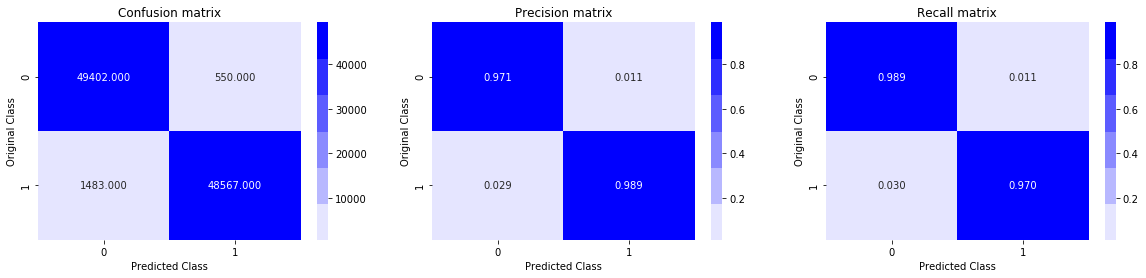

Test confusion_matrix


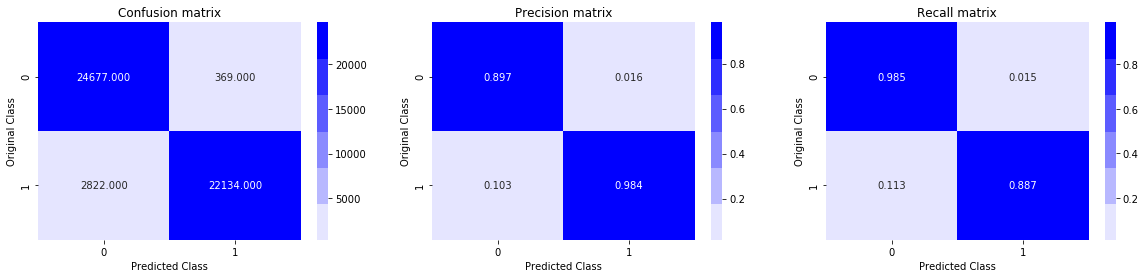

In [54]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

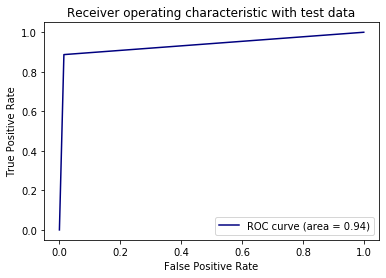

In [55]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

In [61]:
print('train auc',roc_auc_score(y_train,y_train_pred))  #auc score for train and test
print('test auc',roc_auc_score(y_test,y_test_pred))

train auc 0.9796795301111445
test auc 0.9360940447233767


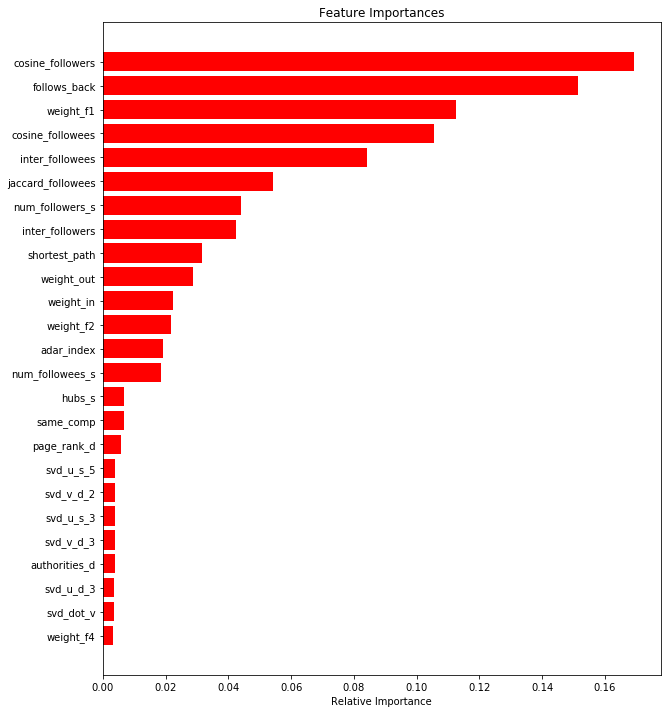

In [62]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()